<a href="https://colab.research.google.com/github/arbeeorlar/data_science/blob/main/MLS1_Customer_Sentiment_Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=10>Artificial Intelligence and Machine Learning</center></font></h1>
<h1><center>Attention Mechanisms and Transformers - Airline Customer Review Sentiment Analysis</center></h1>

<center><img src="https://images.pexels.com/photos/3769532/pexels-photo-3769532.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" width="1300" height="500"></center>

<b><h2><center> Airline Customer Review Sentiment Analysis </center></h2></b>

## Problem Statement

### Business Context

In today's digital age, social media platforms like Twitter have become a prominent channel for customers to share their experiences and opinions, and the airline industry is no exception. Passengers frequently turn to Twitter to express their thoughts, feelings, and experiences related to their air travel. The ease of access and immediacy of social media has empowered customers to voice their opinions in real-time, making it a valuable source of feedback for airlines. The airline company recognized the immense value of these insights to understand customer sentiment and continuously enhance the travel experience.

However, the airline company faces a significant challenge with the rise of negative feedback on social media. Negative sentiments expressed by customers become a crucial problem to solve as they can lead to several detrimental effects, including:

1. Customer Churn: Unaddressed negative sentiment can lead to customer dissatisfaction and ultimately result in passengers choosing competitors for their future travel needs. This translates to a loss of loyal customers, impacting long-term revenue and market share.

2. Reputation Damage: Persistent negative sentiment, if left unmanaged, can tarnish an airline's reputation, and influence potential passengers to avoid booking with the airline. A damaged reputation can have lasting consequences, affecting brand loyalty and trust.

3. Financial Loss: Loss of revenue can occur if negative sentiment drives passengers away, impacting the airline's profitability and long-term success. Negative feedback can discourage potential passengers from making bookings with the airline, leading to direct financial repercussions

### Problem Definition

The airline has noticed a trend as it grew - the amount of feedback coming through conventional channels (airline feedback forms, surveys, etc.) has reduced and customers have started sharing their feedback by tagging the airline's official social media handles. The volume of feedback being received on social media has significantly increased (~25%) over the past six months. In particular, the official Twitter handle of the airline saw a 50% increase in mentions. While they were initially tracking the social media feedback manually, the recent increase in volume has made it difficult to continue the same. This has prompted the airline to seek an AI-based solution to analyze the feedback provided by customers on social media. They believe that such a solution will be more effective than their current methods and provide insights that can proactively help them minimize revenue loss. As a first step, they want to start by assessing the feedback provided by customers on social media and categorizing the sentiment of the customer as negative, positive, or neutral.

As a Data Scientist on the airline's Data Team, you are provided with the tweets shared by customers regarding their experience with the airline's services. The objective is to analyze the data and build a predictive model that can parse the customer reviews and predict the sentiment of the customer.

### Data Dictionary

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

## Importing the necessary libraries

In [1]:
# installing necessary libraries
!pip install --quiet transformers bitsandbytes accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 18.4 MB/s eta 0:00:00


In [2]:
# importing libraries for data manipulation
import numpy as np
import pandas as pd

# importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# importing NLP tool-kit library and functions
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud,STOPWORDS

# function for splitting the data
from sklearn.model_selection import train_test_split

# function for loading the model
from transformers import T5Tokenizer, T5ForConditionalGeneration

# importing metric functions
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Loading the dataset

In [3]:
# mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/NLP/Transformer/US_Airways.csv')

In [5]:
# creating a copy of the dataset
data = df.copy()

## Data Overview

### Checking the first five rows of the data

In [6]:
# Print first 5 rows of data
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570310600460525568,negative,0.6292,Flight Booking Problems,0.3146,US Airways,NaN,jhazelnut,NaN,0,@USAirways is there a better time to call? My...,NaN,2015-02-24 11:53:37 -0800,NaN,NaN
1,570310144459972608,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,GAKotsch,NaN,0,@USAirways and when will one of these agents b...,NaN,2015-02-24 11:51:48 -0800,NaN,Atlantic Time (Canada)
2,570309340952993796,neutral,1.0000,NaN,NaN,US Airways,NaN,DebbiMcGinnis,NaN,0,@USAirways is a DM possible if you aren't foll...,NaN,2015-02-24 11:48:37 -0800,Missourah,Hawaii
3,570309000279023616,neutral,1.0000,NaN,NaN,US Airways,NaN,AshleyKAtherton,NaN,0,@USAirways Fortunately you have staff like Lyn...,NaN,2015-02-24 11:47:16 -0800,NaN,Central Time (US & Canada)
4,570308799950692353,negative,1.0000,Customer Service Issue,0.6452,US Airways,NaN,retardedlarry,NaN,0,@USAirways just hung up on me again. Another ...,NaN,2015-02-24 11:46:28 -0800,NaN,NaN


In [7]:
# checking a customer review
data['text']

,text
0,@USAirways is there a better time to call? My...
1,@USAirways and when will one of these agents b...
2,@USAirways is a DM possible if you aren't foll...
3,@USAirways Fortunately you have staff like Lyn...
4,@USAirways just hung up on me again. Another ...
...,...
2908,@USAirways I have been on hold with your Gold ...
2909,.@USAirways we have no choice but to pay anoth...
2910,@USAirways reservations had me on hold for 2 h...
2911,@USAirways @AmericanAir How r u supposed to ch...


### Checking the shape of the dataset

In [8]:
# print shape of data
data.shape

(2913, 15)

* The data comprises of ~3k customer reviews

### Checking for Missing Values

In [9]:
# Check for NULL values
data.isnull().sum(axis=0)

,0
tweet_id,0
airline_sentiment,0
airline_sentiment_confidence,0
negativereason,650
negativereason_confidence,443
airline,0
airline_sentiment_gold,2910
name,0
negativereason_gold,2911
retweet_count,0


* There are missing values across multiple columns

### Checking the statistical summary

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,2913.0,5.691208e+17,7.676358e+14,5.676433e+17,5.684797e+17,5.693176e+17,5.697157e+17,5.703106e+17
airline_sentiment_confidence,2913.0,9.215784e-01,1.499961e-01,3.400000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,2470.0,6.871717e-01,3.078601e-01,0.000000e+00,6.223500e-01,6.777000e-01,1.000000e+00,1.000000e+00
retweet_count,2913.0,8.547889e-02,1.172269e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


- `tweet_id` is a unique ID for a tweet, so we can discard it from our analysis
- We see that there is minimal retweeting of customers tweets
    - However, this might vary by customer sentiment, so we'll check for that later

## Exploratory Data Analysis (EDA)


In [11]:
 # function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

#### Distribution of sentiments

/tmp/ipython-input-3020376056.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


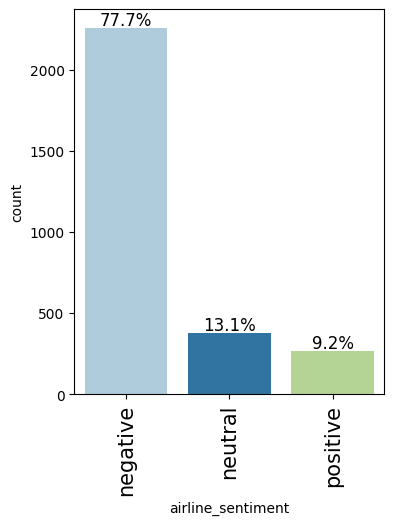

In [12]:
labeled_barplot(data, "airline_sentiment", perc=True)

- Majority of the tweets are negative (78%), followed by neutral tweets (13%), and then the positive tweets (9%)

#### Distribution of negative sentiment reasons

/tmp/ipython-input-3020376056.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


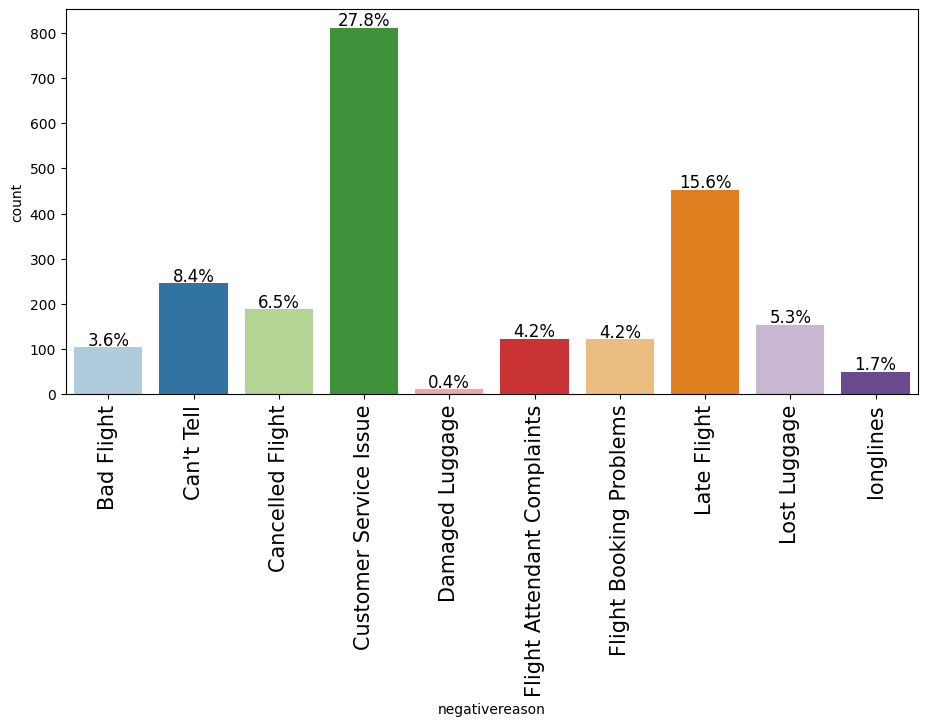

In [13]:
labeled_barplot(data, "negativereason", perc=True)

* The predominant causes of negative tweets appear to be customer service issues (28%) and late flights (16%)

#### Distribution of retweets

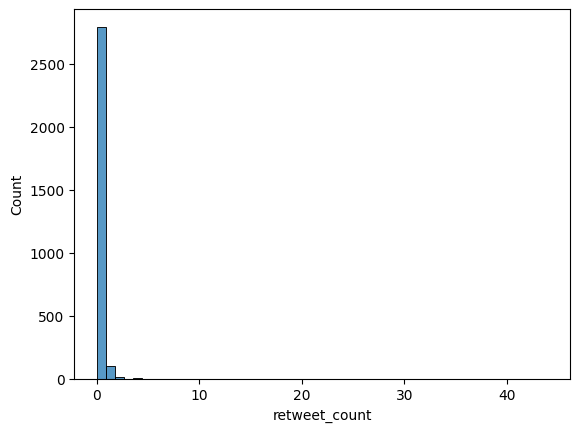

In [14]:
sns.histplot(data, x='retweet_count', bins =50);

- A majority of the customer tweets are not re-tweeted
- The lower number of retweet counts suggests that customers are less inclined to retweet

### Bivariate Analysis

Let's check the relationship between retweets and customer sentiment

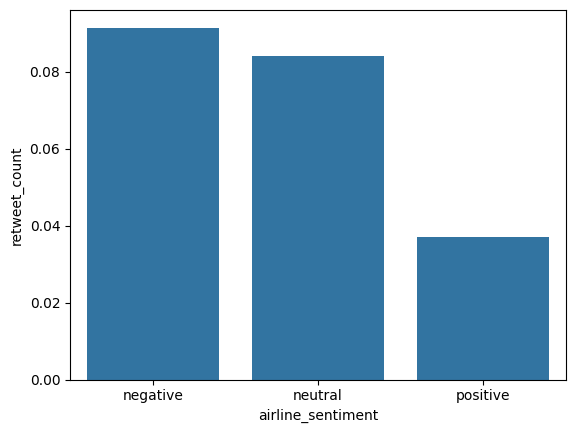

In [15]:
sns.barplot(data, y='retweet_count', x='airline_sentiment', errorbar=('ci', False));

* On average, negative sentiment tweets get re-tweeted the most


In order to analyze the text, we need to do some processing of the text column that contains customer reviews. The steps involved are as follows:

1. Splitting the Words:
This step involves breaking down the text into individual words. By splitting the text, we can later analyze and manipulate each word separately, allowing for a more granular understanding of the content.

2. Excluding Words Containing 'http':
Words containing 'http' are likely to be URLs or links. These elements might not provide meaningful information for sentiment analysis and can be excluded from our analysis to focus on the actual textual content of the reviews.

3. Excluding Words Starting with '@':
Words starting with '@' in the context of social media are mentions or references to usernames, often indicating the airline being discussed. By excluding these mentions, we can streamline our analysis to focus on the sentiment expressed in the reviews without being influenced by direct references to the airline.

4. Excluding 'RT':
The term 'RT' typically stands for "Retweet" and is commonly used on social media platforms like Twitter. In the context of customer reviews, 'RT' may not contribute substantially to the sentiment expressed and can be safely excluded from our analysis.

#### Wordcloud for negative tweets

In [16]:
# Extracting all rows with 'negative' sentiment from the 'airline_sentiment' column and creating a copy
negative_cust_reviews = data[data['airline_sentiment'] == 'negative'].copy()

# Concatenating all the text from the 'negative_cust_reviews' into a single string
words_negative = ' '.join(negative_cust_reviews['text'])

# Cleaning the text by removing words that contain 'http', start with '@', and are 'RT'
cleaned_words_negative = " ".join(
    [
        word for word in words_negative.split()    # Splitting the words
        if 'http' not in word             # Excluding words containing 'http'
        and not word.startswith('@')      # Excluding words starting with '@'
        and word != 'RT'                  # Excluding 'RT'
    ]
)

In [17]:
# Creating a WordCloud object with specified settings
wordcloud_negative = WordCloud(
    stopwords=STOPWORDS,            # Providing a set of stopwords to exclude from the word cloud
    background_color='black',       # Setting the background color of the word cloud
    width=3000,                     # Setting the width of the word cloud image
    height=2500                     # Setting the height of the word cloud image
).generate(cleaned_words_negative)           # Generating the word cloud from the cleaned words

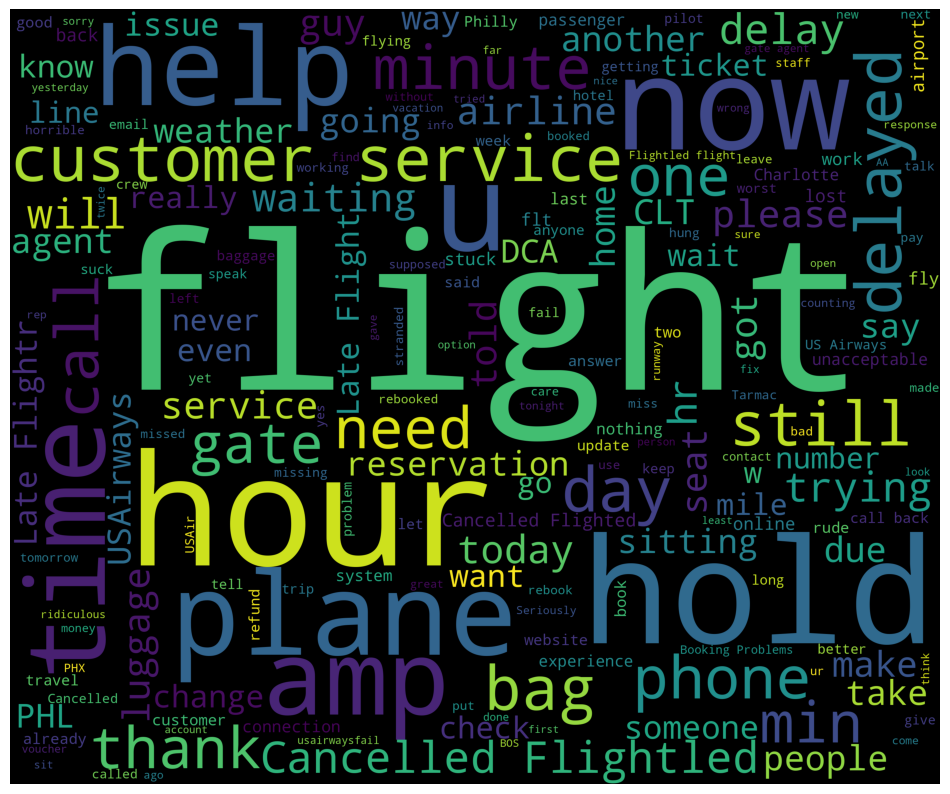

In [18]:
# plot the negative words
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.show()

- Tweets with negative sentiment frequently contain words like *cancelled*, *customer service*, *hold*, and *delayed*
- People might guess that customer tends to have a negative sentiment when their flights get delayed/cancelled or the customer service is poor - which is what one would expect

#### Wordcloud for positive tweets

In [19]:
# Extracting all rows with 'negative' sentiment from the 'airline_sentiment' column and creating a copy
positive_cust_reviews = data[data['airline_sentiment'] == 'positive'].copy()

# Concatenating all the text from the 'negative_cust_reviews' into a single string
words_positive = ' '.join(positive_cust_reviews['text'])

# Cleaning the text by removing words that contain 'http', start with '@', and are 'RT'
cleaned_words_positive = " ".join(
    [
        word for word in words_positive.split()    # Splitting the words
        if 'http' not in word             # Excluding words containing 'http'
        and not word.startswith('@')      # Excluding words starting with '@'
        and word != 'RT'                  # Excluding 'RT'
    ])

In [20]:
# Creating a WordCloud object with specified settings
wordcloud_positive = WordCloud(
    stopwords=STOPWORDS,            # Providing a set of stopwords to exclude from the word cloud
    background_color='black',       # Setting the background color of the word cloud
    width=3000,                     # Setting the width of the word cloud image
    height=2500                     # Setting the height of the word cloud image
).generate(cleaned_words_positive)           # Generating the word cloud from the cleaned words

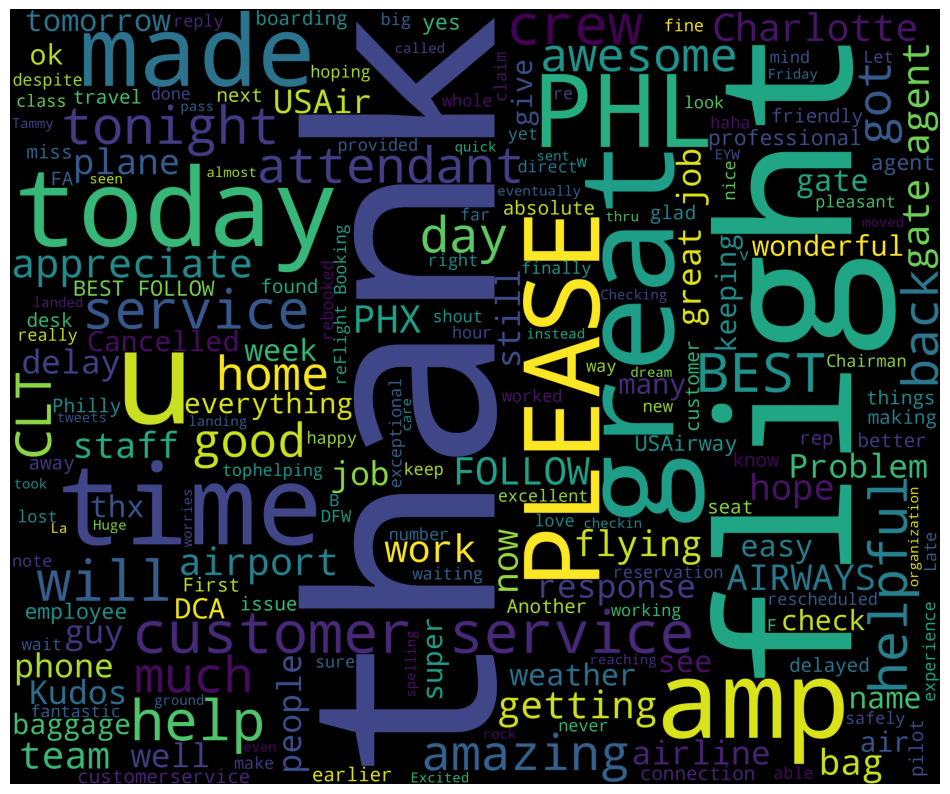

In [21]:
# plot the positive words
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.show()

- Tweets with positive sentiment frequently contain words like *thank*, *great*, *appreciate*, and *kudos*
- These words portray satisfaction - which is what we would expect from customers with a positive sentiment
- Other words like *crew*, *attendant*, and *staff* highlight a positive experience during the flight

## Data Preprocessing

In [22]:
# Specify the features (X) and the target variable (y)
X = data.drop('airline_sentiment', axis=1)  # Replace 'target_variable' with the actual name of your target column
y = data['airline_sentiment']

In [23]:
# splitting data into validation and test sets
X_validation, X_test, y_validation, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**Note**:
- We are not creating a separate train set as we'll be loading a pre-trained transformer model
- We do not need to train the model - we can directly load it and use it for predictions

In [24]:
# Creating a copy of the 'text' column from the validation dataset
text_column_validation = X_validation['text'].copy()

# Creating a copy of the actual sentiment labels from the validation dataset
actual_sentiment_validation = y_validation.copy()

In [25]:
# Creating a copy of the 'text' column from the test dataset
text_column_test = X_test['text'].copy()

# Creating a copy of the actual sentiment labels from the test dataset
actual_sentiment_test = y_test.copy()

## Model Loading and Evaluation

In practice, we **generally do not create transformer models from scratch** as

1. creating transformer models from scratch is computationally demanding and requires substantial processing power
2. training a transformer model from scratch demands large, labeled datasets, which can be challenging to obtain

**We use pre-trained transformer models for most common applications.**

We'll be using the **Google FLAN-T5** model here.

💡 **FLAN-T5, developed by Google Research, is a "Fine-tuned LAnguage Net" (FLAN) with "Text-To-Text Transfer Transformer" (T-5) architecture.**

📊 **FLAN-T5 excels in various NLP tasks**, including translation, classification, and question answering, and it's known for its speed and efficiency.

📋 FLAN-T5 comes in different sizes: small, base, large, XL, and XXL, offering customization options.

🛠️ Potential use-cases include text generation, classification, summarization, sentiment analysis, question-answering, translation, and chatbots.

In [29]:
# Initializing a T5 tokenizer using the pre-trained model "google/flan-t5-large"
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

# Initializing a T5 model for conditional generation using the pre-trained model "google/flan-t5-large"
# Loading the model in 8-bit quantized format for efficiency
# Setting the device mapping to "auto" for automatic device assignment (this will automatically detect available GPUs and use it)
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", load_in_8bit=True, device_map="auto")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [31]:
# def preprocess(batch):
#     model_inputs = tokenizer(batch["instruction"], truncation=True)
#     labels = tokenizer(batch["output"], truncation=True).input_ids
#     model_inputs["labels"] = labels
#     return model_inputs

In [30]:
# defining a function to generate, process, and return the response
def generate_response(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")    ### using the tokenizer to create tokens in tensor format from an input
    outputs = model.generate(input_ids, max_length=300, do_sample=True, temperature=0.001)    ### generating the model output in tensor format
    return tokenizer.decode(outputs[0])[6:-4]    ### using the tokenizer to decode the model output, and then return it

In the `generate()` function defined above, the following arguments were used:

1. `max_length`: This parameter determines the maximum length of the generated sequence. In the provided code, max_length is set to 300, which means the generated sequence should not exceed 300 tokens.

2. `temperature`: The temperature parameter controls the level of randomness in the generation process. A higher temperature (e.g., closer to 1) makes the output more diverse and creative but potentially less focused, while a lower temperature (e.g., close to 0) produces more deterministic and focused but potentially repetitive outputs. In the code, temperature is set to 0.001, indicating a very low temperature and, consequently, a more deterministic sampling.

3. `do_sample`: This is a boolean parameter that determines whether to use sampling during generation (do_sample=True) or use greedy decoding (do_sample=False). When set to True, as in the provided code, the model samples from the distribution of predicted tokens at each step, introducing randomness in the generation process.

In [32]:
# checking a customer review and it's sentiment
print('Review:\t', text_column_validation[4])
print('Actual Sentiment:\t', actual_sentiment_validation[4])

Review:	 @USAirways just hung up on me again.  Another waste of an hour of my time.  How am I supposed to book a one way award flight?  #badwebsite
Actual Sentiment:	 negative


In [33]:
# defining a prompt which tells the model what to do
sys_prompt = """
    Categorize the sentiment of the customer review as positive, negative, or neutral.
    Leverage your expertise in the aviation industry and deep understanding of industry trends to analyze the nuanced expressions and overall tone.
    It is crucial to accurately identify neutral sentiments, which may indicate a balanced view or neutral stance towards Us Airways. Neutral expressions could involve factual statements without explicit positive or negative opinions.
    Consider the importance of these neutral sentiments in gauging the public sentiment towards the airline company.
    For instance, a positive sentiment might convey satisfaction with the airline's services, a negative sentiment could express dissatisfaction, while neutral sentiment may reflect an impartial observation or a neutral standpoint
"""

# predicting the sentiment using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        Review text: '{}'
    """.format(sys_prompt, text_column_validation[4])
)

print(pred_sent)

negative


- The model was able to correctly identify the sentiment here

**Note**: We'll discuss more about prompts, types of prompts, and how to effectively write them to optimize LLM outputs in upcoming classes.

In [34]:
# defining a function to generate a sentiment prediction
def predict_sentiment(review_text):
    pred = generate_response(
        """
            {}
            Review text: '{}'
        """.format(sys_prompt, review_text)
    )

    return pred

In [35]:
predicted_sentiment = [predict_sentiment(item) for item in text_column_validation.values]


negative


In [37]:
print(predicted_sentiment[40])

negative


In [38]:
# combining the reviews, actual sentiments, and predicted sentiments together
df_combined = pd.concat([text_column_validation, actual_sentiment_validation], axis=1)
df_combined['predicted_sentiment'] = predicted_sentiment
df_combined.head()

,text,airline_sentiment,predicted_sentiment
439,@USAirways US 728/Feb 21. Ground power shorts ...,negative,negative
1621,@USAirways now the 3rd issue with the plane is...,negative,negative
423,@USAirways I need to speak with a customer ser...,negative,negative
2330,@USAirways delays to the max,negative,negative
1706,@USAirways Can you tell me why I waited 90 min...,negative,negative


In [39]:
# creating confusion matrix
cnf_mt = confusion_matrix(df_combined['airline_sentiment'], df_combined['predicted_sentiment'], labels=['positive', 'neutral', 'negative'])
# computing accuracy
acc = accuracy_score(df_combined['airline_sentiment'], df_combined['predicted_sentiment'])

Accuracy: 0.8386112170927127


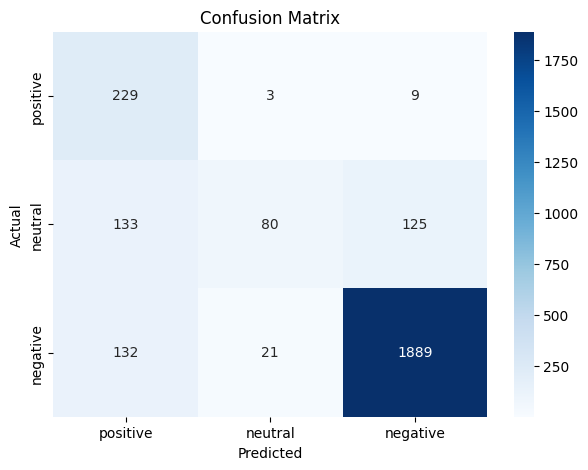

In [40]:
# printing accuracy
print("Accuracy:", acc)

# creating a heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(
    cnf_mt,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['positive', 'neutral', 'negative'],
    yticklabels=['positive', 'neutral', 'negative'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- The model achieved ~84% accuracy

## Model Testing

In [41]:
predicted_sentiment_test = [predict_sentiment(item) for item in text_column_test.values]
print(predicted_sentiment_test[4])

negative


In [42]:
# combining the reviews, actual sentiments, and predicted sentiments together
df_combined = pd.concat([text_column_test, actual_sentiment_test], axis=1)
df_combined['predicted_sentiment'] = predicted_sentiment_test
df_combined.head()

,text,airline_sentiment,predicted_sentiment
178,@USAirways it doesn't take 6 days to respond t...,negative,negative
678,@USAirways And how do you only have 1 agent at...,negative,negative
2873,@USAirways will do. Hoping for a voucher for a...,positive,positive
2686,@USAirways and if the flight is full?,neutral,neutral
1898,@sarahpompei don't bother wasting your time! ...,negative,negative


In [43]:
# creating confusion matrix
cnf_mt_tuned = confusion_matrix(df_combined['airline_sentiment'], df_combined['predicted_sentiment'], labels=['positive', 'neutral', 'negative'])
# computing accuracy
acc_tuned = accuracy_score(df_combined['airline_sentiment'], df_combined['predicted_sentiment'])

Accuracy: 0.8253424657534246


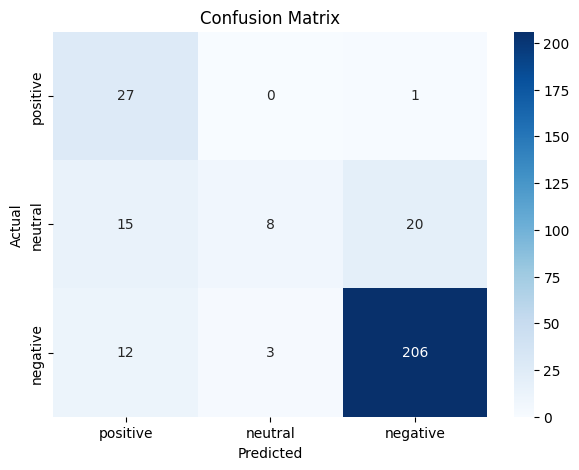

In [44]:
# printing accuracy
print("Accuracy:", acc_tuned)

# creating a heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(
    cnf_mt_tuned,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['positive', 'neutral', 'negative'],
    yticklabels=['positive', 'neutral', 'negative'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- The test accuracy of the model is also ~82%


There is an interesting observation from the confusion matrices above.

- The model is not able to correctly capture the nuances of neutral sentiments for quite a few customers
- This deficiency has the potential to introduce misinformation into decision-making processes, potentially distorting analytics and strategic planning. Such inaccuracies could, in turn, impact the services offered and the effectiveness of engagement strategies


We have two options to deal with the situation.

1. We can try out a different transformer-based model
2. We can improve the performance of this model for this task

There are two approaches to improving the performance of the model here.

1. **Fine-tuning the Model**
2. **Prompt Engineering**

We'll learn more about both these approaches in the upcoming classes.

## Summary

- We analyzed the distribution of negative reasons and identified customer service issues and late flights as the predominant factors driving negative sentiments

- We processed the text data to analyze it and gain insights into what could have resulted in negative and positive customer experiences through word clouds

- We used the Google FLAN-T5 model to build a sentiment analyzer that achieved ~82% accuracy

- The model, however, was unable to capture the nuances of neutral sentiments well enough to make accurate predictions in those cases

- Once we improve the performance of the model, we can use the model to make informed decisions to enhance the services provided by the airline to offer a better customer experience

___